# Predicting Season from Temperature and Humidity

## Load Data

In [1]:
import numpy as np
from numpy import polyfit
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go 
import plotly

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils

import scripts.fetch_data as data
from scripts.plot import slider_plotly


Using TensorFlow backend.


## Load Data

In [2]:
df = data.dwd(2013, 2017, '/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt')
df.head()

,Temp,Humi
datetime,,
2013-01-01 00:00:00,8.4,70.0
2013-01-01 01:00:00,8.4,70.0
2013-01-01 02:00:00,8.4,69.0
2013-01-01 03:00:00,8.7,68.0
2013-01-01 04:00:00,8.5,69.0


In [3]:
df = df.resample('M').mean()
df.head()

,Temp,Humi
datetime,,
2013-01-31,0.627957,88.754032
2013-02-28,0.075149,88.358631
2013-03-31,-0.523118,78.118280
2013-04-30,8.630972,69.386111
2013-05-31,12.421505,78.838710


In [4]:
plotly.offline.init_notebook_mode(connected=True)

## Display Horizon : Bokeh

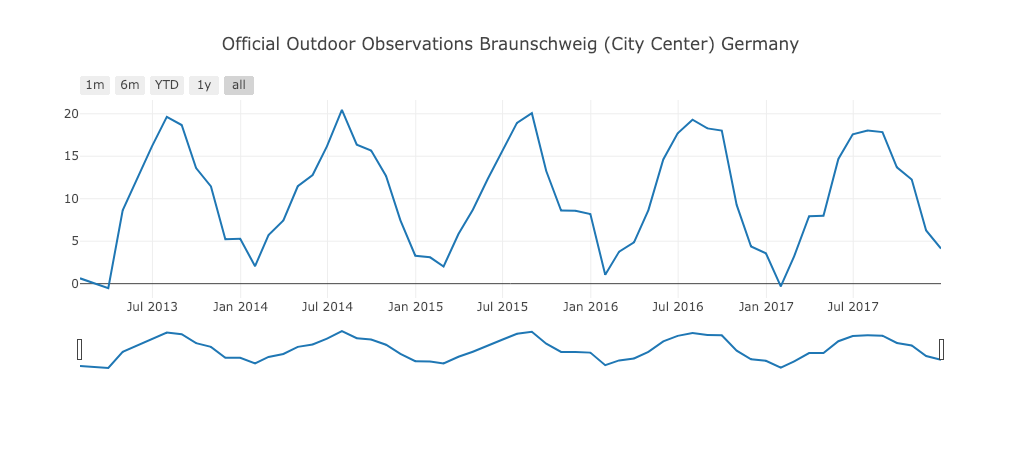

In [4]:
plotly.offline.init_notebook_mode(connected=True)
fig = plot.plotly_slider(df, 'Temp' , 'Official Outdoor Observations Braunschweig (City Center) Germany')
plotly.offline.iplot(fig)

In [9]:
# https://community.plot.ly/t/setting-initial-plot-to-be-a-subset-of-input-data-using-buttons-and-drop-downs/6624/2
# https://plot.ly/python/dropdown-widget/#simple-dropdown-widget

def slider(df, title):

    trace_temp = go.Scatter(x=list(df.index),
                            y=list(df.Temp),
                            name='Temperature',
                            line=dict(color='#3FA65F'))
  
    trace_humi = go.Scatter(x=list(df.index),
                            y=list(df.Humi),
                            name='Humidity',
                            line=dict(color='#F06A6A'))
    
    # problem selecting both from beginning
    data = [trace_temp]
    
    # invoke update function get new values of x and y then relayout 
    updatemenus = list([
    dict(
        buttons=list([   
            dict(label = 'Temperature',
                 method = 'update',
                 args = [{'y': [df.Temp]},
                         {'title': 'Temperature'}]),
           
             dict(label = 'Humidity',
                 method = 'update',
                 args = [{'y': [df.Humi]},
                         {'title': 'Humidity'}])
        ]),
        direction = 'down',
        pad = {'r': 10, 't': 10},
        showactive = True,
        xanchor = 'left',
        yanchor = 'top'
    )
])
    
    
    layout = dict(updatemenus=updatemenus,
                  title=title,
                  xaxis=dict(
                      rangeselector=dict(
                          buttons=list([
                              dict(count=1,
                                   label='1m',
                                   step='month',
                                   stepmode='backward'),
                              dict(count=6,
                                   label='6m',
                                   step='month',
                                   stepmode='backward'),
                              dict(count=1,
                                   label='YTD',
                                   step='year',
                                   stepmode='todate'),
                              dict(count=1,
                                   label='1y',
                                   step='year',
                                   stepmode='backward'),
                              dict(step='all')
                          ])
                      ),
                      rangeslider=dict(
                          visible=True
                      ),
                      type='date'
                  )
              )

    fig = dict(data=data, layout=layout)
    return fig


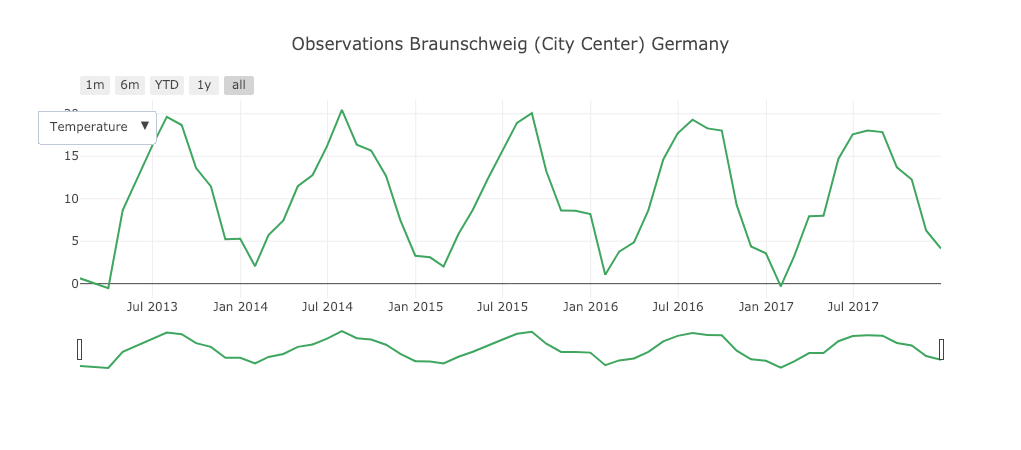

In [7]:
fig = slider_plotly(df, 'Observations Braunschweig (City Center) Germany')
plotly.offline.iplot(fig, filename='update_dropdown')

## Display Horizon Using Bokeh 

In [11]:
# Change the variable "col" to diplay a different column
col = 'Humi'

dates = df.index.values
source = ColumnDataSource(data=dict(date=dates, close=df[col]))

p = figure(title= col + ": Official Outdoor Observations Braunschweig (City Center) Germany (2013 - 2016)" ,
           plot_height=300, plot_width=800, tools="", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[0], dates[df[col].shape[0]-1]))

p.line('date', 'close', source=source)
p.yaxis.axis_label = 'Celcius'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))

## Infer Target Variables

In [23]:
#Infer target season 
#German Seasons
#SeasonID; Season Name; Month
#2; Spring; March, April, May
#3; Summer; June, July, August
#4; Autumn; September, October, November
#1; Winter; December, January, February
#spring = range(3, 5)
#summer = range(6, 8)
#fall = range(9, 11)
def season(month):
    if month not in range(1,13):
        return np.NaN
        #raise Exception('month must be integer value in interval [1...12] inclusive. The value of x was: {}'.format(month))
    return (month%12 + 3)//3

# if we use the month as a feature, it should be trivial to predict season from month
df['month'] = df.index.month

# target variable: 
df['season'] = df.index.to_series().apply(lambda m : season(m.month))
df.head()

,Temp,Humi,month,season
datetime,,,,
2010-01-31,-3.879973,86.928763,1,1
2010-02-28,-0.284673,82.645833,2,1
2010-03-31,4.991398,75.493280,3,2
2010-04-30,9.473333,64.016667,4,2
2010-05-31,10.425134,79.571237,5,2


In [24]:
# seed the data 
seed = 25
# shuffle the data in the dataframe
df = shuffle(df, random_state=seed)
df.head()

,Temp,Humi,month,season
datetime,,,,
2014-05-31,12.784812,76.481183,5,2
2016-02-29,3.772414,80.014368,2,1
2017-08-31,17.843280,74.766129,8,3
2010-07-31,21.364785,63.053763,7,3
2014-07-31,20.455680,70.830295,7,3


In [25]:
# convert integers to dummy variables (i.e. one hot encoded)
Y = to_categorical(df.season)
#print(Y)

## Train on Month 

In [29]:
X = np_utils.to_categorical(df.month)
print(X[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X, Y)
print(clf.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]))

[[0. 1. 0. 0. 0.]]


In [26]:
# evaluate the model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [73]:
results = cross_val_score(clf, X, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 100.00% (0.00%)


## Train Temp and Humidy

In [27]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

df = df.dropna(axis=0)
X = df[['Temp','Humi']]
scaler.fit(X)  
X_train = scaler.transform(X)  
Y = np_utils.to_categorical(df.season)

clf = RandomForestClassifier(n_estimators=30,  random_state=0)
clf.fit(X, Y)

results = cross_val_score(clf, X_train, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 86.33% (8.17%)
